**02_BCF2SS Model___BCF___Block-Centered Flow Package**

In [1]:
import os ; import pathlib as pl ; import flopy ; import git ; import matplotlib as mpl ; import matplotlib.pyplot as plt; import pandas as pd
import numpy as np ; from flopy.plot.styles import styles ; from modflow_devtools.misc import get_env, timed; from pathlib import Path

In [2]:
sim_name = "ex-gwf-bcf2ss" ; output_folder = Path("./02_BCF2SS")        ; output_folder.mkdir(exist_ok=True)  
data_file_with_path = os.path.join('E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-bcf2ss', "wetdry01.txt")    
wetdry_layer0 = np.loadtxt(data_file_with_path)   # _____________________________________________________________input 01 
workspace = output_folder ; figs_path = output_folder; np.savetxt(workspace/"a_wetdry_layer0.csv", wetdry_layer0, delimiter = ",")    

In [3]:
length_units = "feet" ; time_units = "days"
parameters = {"ex-gwf-bcf2ss-p01a": {"rewet": True,"wetfct": 1.0,"iwetit": 1,"ihdwet": 0,"linear_acceleration": "cg","newton": None},
              "ex-gwf-bcf2ss-p02a": {"rewet": False,"wetfct": None,"iwetit": None,"ihdwet": None,"linear_acceleration": "bicgstab","newton": "NEWTON"}}

In [4]:
nper = 2 ;               nlay = 2 ;nrow = 10 ;ncol = 15 ;delr = 500 ;delc = 500            ;top = 150 ;botm_str = "50.0,-50." ;icelltype_str = "1,0"   
k33 = 0.1 ;  strt = 0 ;  recharge = 0.004 ;  nouter = 500 ;  ninner = 100 ;  hclose = 0.000001 ;  rclose = 0.001 ;  relax = 0.97 ;  k11_str = "10,5"
tdis_ds = ((1.0, 1.0, 1),(1.0, 1.0, 1),)                           

botm = [float(value) for value in botm_str.split(",")]            
icelltype = [int(value) for value in icelltype_str.split(",")]     ; k11 = [float(value) for value in k11_str.split(",")]
wel_spd = {1: [[1, 2, 3, -35000.0],[1, 7, 3, -35000.0],]}          ; riv_spd = {0: [[1, i, 14, 0.0, 10000.0, -5] for i in range(nrow)]}

In [5]:
with open(workspace/'_a_parameters.txt', 'w') as f:             # ModflowIms
    print(parameters, file=f)    

wel_spd (2, 1)
river (10, 6)
sufaces [[150.0], [50.0], [-50.0]]


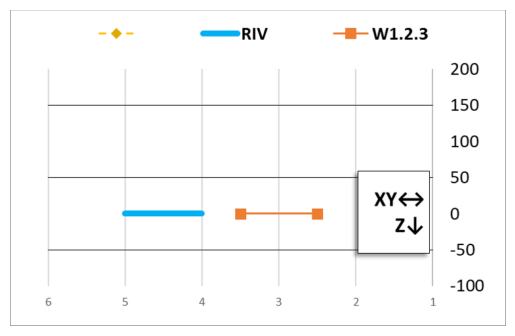

In [6]:
row = wel_spd ; sa = pd.DataFrame(row)      ;  sa.to_csv (output_folder / "b_wel_spd.csv")      ; print('wel_spd',sa.shape)
row = riv_spd  [0] ; sa = pd.DataFrame(row) ;  sa.to_csv (output_folder / "c_river.csv")        ; print('river',sa.shape)
# top_list = [top]; top_list.extend([i-top for i in botm])                                      ; print('layers_err',top_list)  # see ex:01
top=[top] ;sa1=pd.DataFrame(top) ;sa2=pd.DataFrame(botm) ;fr=[sa1,sa2] ;rs=pd.concat(fr) ; rs=rs.values.tolist() ; print('sufaces',rs)
image = plt.imread('_aux\\02_BCF2SS.png'); fig, ax = plt.subplots() ; ax.imshow(image) ; ax.axis('off') ; plt.show() 

In [7]:
rewet = []
if rewet:
    rewet_record = ["wetfct", wetfct, "iwetit", iwetit, "ihdwet", ihdwet]       ; wetdry = [wetdry_layer0, 0]
else:
    rewet_record = None  ; wetdry = None

In [8]:
sim_ws = os.path.join(output_folder, sim_name)
sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
flopy.mf6.ModflowIms(sim,linear_acceleration='bicgstab'    , outer_maximum=nouter, outer_dvclose=hclose,         # linear  cg  bicgstab
                     inner_maximum=ninner, inner_dvclose=hclose,rcloserecord=f"{rclose} strict",relaxation_factor=relax)
gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True, newtonoptions="NEWTON")
flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)

flopy.mf6.ModflowGwfnpf(gwf,rewet_record=rewet_record,      wetdry=wetdry,icelltype=icelltype,    k=k11,k33=k33,save_specific_discharge=True)
flopy.mf6.ModflowGwfic(gwf, strt=strt)
flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)
flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd)
flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
head_filerecord = f"{sim_name}.hds"
budget_filerecord = f"{sim_name}.cbc"
flopy.mf6.ModflowGwfoc(gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])

sim.write_simulation(silent=False)  ; sim.run_simulation(silent=False)  # False True

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model ex-gwf-bcf2ss...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 10 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...
FloPy is using the following executable to run the model: C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Scripts\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 14 2025 13:40:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on 

(True, [])

In [9]:
sim_ws=os.path.join(workspace,sim_name) ;gwf=sim.get_model(sim_name) ; hobj=gwf.output.head() ; head=hobj.get_data() ; cobj=gwf.output.budget()  
print('heads=', head.shape); sv = head.reshape(head.shape[0],-1)     ; then=pd.DataFrame(sv)  ; then.to_csv (output_folder / 'd_H_3D.csv' )  

heads= (2, 10, 15)


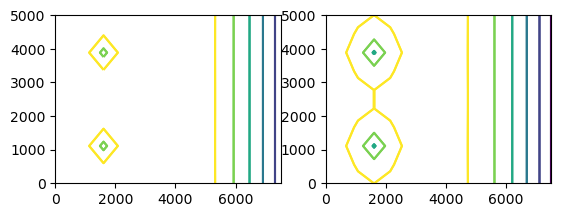

In [10]:
def annotate_axes(fig):
    for i, ax in enumerate(fig.axes):
        L = 0; ax1.contour( head [L,:,:]   ,levels=np.arange(L, np.percentile(sv[0],95),10)   , extent=gwf.modelgrid.extent)
        L = 1; ax2.contour( head [L,:,:]   ,levels=np.arange(L, np.percentile(sv[0],95),10)   , extent=gwf.modelgrid.extent)
fig = plt.figure()    ; ax1 = plt.subplot2grid((2, 2), (1, 0))        ; ax2 = plt.subplot2grid((2, 2), (1, 1))  ; annotate_axes(fig) ; plt.show()

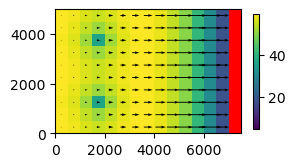

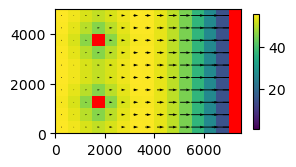

In [11]:
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)
fig = plt.figure(figsize=(3, 3))          
L = 0 ; mm = flopy.plot.PlotMapView(model=gwf, layer=L, extent=gwf.modelgrid.extent) 
cbv = mm.plot_array(head) ; q = mm.plot_vector(qx, qy)  ; cb = plt.colorbar(cbv, ax=mm.ax, shrink=.5) # grid, vectors, Legend
mm.plot_bc(ftype="RIV", color="red", plotAll=True)

qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)
fig = plt.figure(figsize=(3, 3))          
L = 1 ; mm = flopy.plot.PlotMapView(model=gwf, layer=L, extent=gwf.modelgrid.extent) 
cbv = mm.plot_array(head) ; q = mm.plot_vector(qx, qy)  ; cb = plt.colorbar(cbv, ax=mm.ax, shrink=.5) # grid, vectors, Legend
mm.plot_bc(ftype="RIV", color="red", plotAll=True); mm.plot_bc(ftype="WEL", kper=1, plotAll=True)

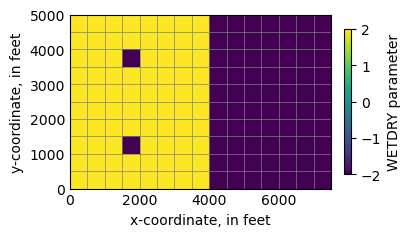

In [12]:
fig = plt.figure(figsize=(4, 3), constrained_layout=True)   ; ax = fig.add_subplot(1, 1, 1) ; ax.set_aspect("equal")
mm = flopy.plot.PlotMapView(model=gwf, ax=ax)  ; wd = mm.plot_array(wetdry_layer0)  ; mm.plot_grid(lw=0.5, color="0.5")
cbar = plt.colorbar(wd, shrink=0.5) ; cbar.ax.set_ylabel("WETDRY parameter")
ax.set_ylabel("y-coordinate, in feet") ; ax.set_xlabel("x-coordinate, in feet") ; styles.remove_edge_ticks(ax) ; plt.show()